# Project Microeconometrics

Author: Benedikt Heinrich Müller, M.Sc. in Economics, Course Microeconometrics, Prof. Dr. Eisenhauer, University of Bonn, Summer term 2020
***

## Introductory Remarks 

In the following I replicate the findings of the 2011 empirical study "*Conscription and Crime: Evidence from the Argentine Draft Lottery*" by Galiani et al. (for exact citation see [section 1](#1.-Brief-Summary-of-the-Journal-Acticle)). Throughout I apply the same nomenclatur as did Galiani et al. (2011), i.e. the tables and figures are enumerated as in the original paper. That is to foster comparability. The data set was well preprocessed. Therefore, replication of the results was straightforward and, hence, I replicate all the empirical figures contained in the paper and the online appendix. <br>
Galiani et al. (2011) used Stata for their analysis. Since Stata was not available to me, I collected the labels of the variables by means of comparison of the .do-file and the results presented in the paper.

## Content of this Notebook 

1. [Brief Summary of the Journal Article](#1.-Brief-Summary-of-the-Journal-Acticle)

    1.1 [Background & Data](#1.1-Background-&-Data)
    
    1.2 [Empirical Strategy](#1.2-Empirical-Strategy)

2. [Replication of Key Findings](#2.-Replication-of-Key-Findings)

    2.1 [Main Results](#2.1-Main-Results)
    
    2.2 [Complementary Results](#2.2-Complementary-Results)
    
    2.3 [Online Appendix](#2.3-Online-Appendix)
    
3. [Extensions](#3.-Extensions)

    3.1 [Extended "Testing" of Exogeneity of Instrument](#3.1-Extended-"Testing"-of-Exogeneity-of-Instrument)

4. [Critical Assessment of Quality](#4.-Critical-Assessment-of-Quality)

[References](#References)

### Import packages.

In [1]:
# Import packages.
import pandas as pd
import statsmodels.api as sm
import numpy as np

from scipy import stats
from linearmodels import IV2SLS
from statsmodels.iolib.summary2 import summary_col

In [2]:
def significance(pval):
    if pval <= 0.01:
        star = '***'
    elif pval <= 0.05:
        star = '**'
    elif pval <= 0.1:
        star = '*'
    else:
        star = ' '
    return star

In [3]:
# Generate cohort dummies.
# Define a function that creates a dummy for a given cohort.
def get_cohort_dummy(df, col, c):
    '''
    Inputs are
    a DataFrame,
    a column col (string), and
    an input c (cohort) for which the output variable shall return 1.
    newcol
    '''
    # Create name of column for cohort c.
    newcol = 'cohort_' + f'{c}'
    # Define a function that creates a dummy var. conditional on another column.
    def dummy_mapping(x):
        if x == c:
            return 1
        elif x == np.nan:
            return np.nan
        else:
            return 0
    df[newcol] = df[col].apply(dummy_mapping)

In [4]:
def get_variables():
    
    # Want to generate global variables.
    global constant
    global highnumber
    global conscription
    global crimerate
    global malvinas
    global navy
    global origin
    global cohorts
    global districts
    global hn_malvinas
    
    # For the regressions below, add a constant to the data frame.
    df['constant'] = 1
    # Get a variable representing the string constant.
    constant = ['constant']
    # Same for 'highnumber' and 'sm'.
    highnumber = ['highnumber']
    conscription = ['sm']
    crimerate = ['crimerate']
    malvinas = ['malvinas']
    navy = ['navy']
    # Get list of origin dummy names. Omit 'argentine' i.o.t. avoid multicollinearity.
    origin = ['naturalized', 'indigenous']
    
    # Get cohort dummies from 1929 to 1965. Alternatively use OneHotEncoding.
    for year in list(range(1929, 1966, 1)):
        get_cohort_dummy(df=df, col='cohort', c=year)
    
    # Get list of cohort dummy names.
    cohort_years = list(range(1930, 1966, 1))  # Omit cohort_1929 (multicollinearity).
    cohorts = []
    for i in cohort_years:
        cohorts.append('cohort_' + f'{i}')


    # Get list of district dummy names. District dummies have already been provided in data.
    district_numbers = list(range(2, 25, 1))  # Omit dist1 (multicollinearity).
    districts = []
    for i in district_numbers:
        districts.append('dist' + f'{i}')
        
    # Generate variable hn_malvinas: inteaction term between highnumber and malvinas.
    df['hn_malvinas'] = df.highnumber*df.malvinas
    hn_malvinas = ['hn_malvinas']

In [5]:
%matplotlib inline

In [6]:
#! conda env remove --name student_project_template

In [7]:
#! type environment_project.yml

In [8]:
#! conda env create -f environment.yml

In [9]:
# Do I need to add this to the environment file.
#conda install -c conda-forge linearmodels

In [10]:
#! conda env list

## 1. Brief Summary of the Journal Acticle

#### Full citation:

Galiani, Sebastian, Martín A. Rossi, and Ernesto Schargrodsky. 2011. "Conscription and Crime: Evidence from the Argentine Draft Lottery." *American Economic Journal: Applied Economics*, 3 (2): 119-36.
[DOI: 10.1257/app.3.2.119](http://dx.doi.org/10.1257/app.3.2.119)

 - Do they use individ.-level data? Yes, but they aggregate the data to the level of identical last three digits of the ID.
 - When did the cohorts 1958-1962 serve in the military?
 - Novel feature: Authors study effect of peacetime vs war-time military service on crimerate.
 - Crimerate is the same on the cohort-ID-level for each individ.
 - The authors study the effect of 

### 1.1 Background & Data

Conscription in Argentina has been subject to a draft lottery until the abolishment of mandatory conscription in the 1990s. Galiani et al. use this random assignment to estimate the causal effect of serving in the military on subsequent criminal behaviour. The more important parts of the analysis use data from cohorts 1958 to 1962 (= *core cohorts*).

#### The Argentine Draft Lottery 

The timing is as follows:
1. In an open session in the month of (?) the draft numbers are drawn. For every combination of the last three numbers of the national ID of all men in the birth cohort there is a draft number between 1 and 1,000 drawn.
2. The results of the lottery are publicly announced.
3. Medical examinations of all individuals in the birth cohort are conducted.
4. The exact cutoff number is publicly announced.
5. In the month of (?) individuals with a draft number higher than the cutoff which have passed the medical examination are drafted into the military.
6. Draftees serve in (?) the following year. Draftees start service with 21 years (core cohorts of the analysis).

To avoid confusion, note that in Angrist (1990) an individual was draft eligible if he had a number *smaller* than the cutoff. In the Argentine draft lottery the draft number needed to be *higher* than the cutoff.

The draft age was changed from 18 to 21 in 1955. Thus, the cohorts of 1956 and 1957 were not drafted into the military. Data on draft numbers are available for the cohorts from 1929 to 1965. Later the system of the lottery changes, to the effect that Galinai et al. (2011) could no longer determine which draft numbers were draft eligible. The cohort of 1976 was interesting, since this cohort was not drafted at all due to the abolishment of conscription in Argentina. 

Deferment of military service was possible, but draft eligible status did not change and individual j was still in cohort-ID group of initial draft lottery. Some individuals did not need to join military service: "Clerics, seminarians, novitiates, and any individual with family members dependent upon him for support were exempted from military service.", (Galiani et al. 2011, p. 122).

#### War and Peace 

The novelty of the study by Galiani et al. is that they not only estimate the effects of conspcription in wartime but also in peacetime. This is important out of two reasons: 1. the effects of conscription may differ on whether one served during war or peace and 2. peacetime service is more common than wartime service.

1. The effect of serving in the military may be quite different when exposed to actual combat. Those individuals envolved in combat may suffer from detrimental effects on their mental and physical health. These conditions may have a large impact on their subsequent criminal behaviour after serving in the military and may also lessen labour market outcomes.

2. Conscription during peacetime is more often the case than conscription during wartime. Galiani et al. note that most countries in the world have citizens drafted into military during peacetime. Thus, the effect of serving in the military in peacetime is the more relevant case when evaluating this policy.

From April to June 1982 there was the *Falklands War* between Argentina and the United Kingdom. The cohorts of 1962 and 1963 served during this war. Because of data availability, the authors considered the cohorts from 1958 to 1962 for their main analysis.

#### Data & Important Variables 

Galiani et al. use data provided by various Argentine administrative records.
Because of data privacy issues, they do not provide the raw data of their analysis. One observation in the data set stands for all individuals in the same birth cohort *c* and share the same last three digits of the national ID *i*.


In the following, I describe the most important variables used in the analysis.
The measure of criminal behaviour is the variable *crime rate*, which is also the dependent variable.
Let *n* be the number of individuals *j* in birth cohort *c*, with the same last three digits of their national ID *i*. Further, let $I(j)$ be an identity function returning *1* if individual *j* has a criminal record, and *0* otherwise. Then, *crime rate* is defined as
$$crimerate=\frac{ \sum_{j=1}^n I(j)}{n}$$
Note, that $I(j)$ does not indicate which kind of or how many crimes individual *j* commited. <br>
The variable whose effect the authors want to isolate is *conscription*, represented in the data set by *'sm'* (probably from Spanish *servicio militar*). *Conscription* is the share of individuals in *c* and *i* who served in the military. *Conscription* is probably endogenous and therefore instrumented for.
The potential instrument is the variable *draft eligible*, denoted in the data set by the dummy *'highnumber'*, which returns *1* if the draft number of *c* and *i* is above the cutoff number. The variable *draft number* is also available.
Potential control variables used are birth-cohort, origin (*argentine*, *naturalized*, and *indigenous*), and province dummies (federal states). The latter are denoted *dist* plus a number indicating one of the 24 provinces. The varible *malvinas* (Spanish name of the Falkland Islands) is a dummy which returns *1* if indidviduals of the cohort *c* served during the *Falklands War* in 1982 (for the main analysis only cohort 1962 served during the war).

### 1.2 Empirical Strategy

### Causal Graph Representation 

I start the discussion of the empirical strategy by presenting the causal relationship Galiani et al. (2011) assumed in their study. To this end, I use the graphical representation suggested by Pearl (2014).
Causal graphs were created with [dagitty.net](http://www.dagitty.net/). The following notation is used.
- Edges show the assumed causal relationship.
- Arrows indicate the direction of the causal relationship.
- Blue nodes are observed variables, grey ones are unobserved.
- The outcome variable is denoted by an **I** in a blue node.
- The variable whose effect we want to study is denoted by a triangle in a green node.

#### Causal Graph 1 - Simple Case
<img src='files/dagitty-model_v2.png' alt="Alt text that describes the graphic" title="Causal Graph 1" />

Galiani et al. (2011) want to estimate the effect of conscription on crime rates. The fundamental problem of this endeavour is that the variable *conscription* might be correlated with the error term of *crime rate*. This is, because *crime rate* and *conscription* could both be influenced by third variables. Back-door identification identifies the causal effect of *conscription* on *crime rate* by blocking all back-door paths. According to Winship and Morgan (2007), a back-door path is a path from *conscription* to *crime rate* that starts with a directed edge that points to *conscription*.
There is one back-door path in causal graph 1: *conscription* <- *U* -> *crime rate*. Since *U* is a set of variables that are unobserved, we cannot close this back-door path by adjusting for it. We end up in a state where selection on unobservables is an issue. Selection on unobservables occurs if treatment effect heterogeneity and self-selection are present.

If we instrument *conscription* by the exogenous *draft number*, given the causal relationship implied by causal graph 1, we can isolate the effect of *conscription* on *crime rate*. Exogeneity of *draft number* implies that there is no relationship between *draft number* and *crime rate* other than through *conscription*. In the language of causal graphs this amounts to blocking all back-door paths from *draft number* to *crime rate*. Since there are no back-door paths between those, we can estimate the causal effect of *conscription*.

Since lacking data on labour market experience, Galiani et al. (2011) can estimate the overall-effect of conscription only; they cannot adjust for labour market experience. But since they are mainly interested in the overall effect, this is not a drawback as long as causality is as depicted by causal graph 1.

#### Causal Graph 2 - Compromised Instrument: Violation of the Exogeneity Assumption
<img src='files/dagitty-model(1)_v2.png' alt="Alt text that describes the graphic" title="Causal Graph 2" />

Causal graph 2 differs from the first one, by introducing a relationship between *draft number* and *labour market experience*. The causal effect of *conscription* can now no longer be isolated, since the exogeneity of the instrument is compromised. This possible relationship was proposed by Rosenzweig and Wolpin (2000). They applied their criticism on the Vietnam draft lottery and the article by Angrist (1990). *draft number* could influence *labour market experience* by other ways than just by through the channel of *conscription*, if individuals with a high probability of being drafted face worse labour market conditions. Employers could hesitate from employing someone who is likely to be drafted into the military and would then no longer be available for the job at hand. Whether this criticism is applicable in the case of the Argentine draft lottery, see [section 4](#4.-Critical-Assessment-of-Quality).

#### Causal Graph 3 - More Complex Relationship
<img src='files/dagitty-model(2)_v2.png' alt="Alt text that describes the graphic" title="Causal Graph 3" />

Causal graph 3 introduces the effect of wartime conscription. Wartime military service could have other detrimental effects than peacetime military service. For example, experience of combat could cause mental disorders that have an effect on criminal behaviour. There is a second channel through which mental disorders could influence criminal behaviour. Individuals suffering from mental disorder have probably less success in the labour market than mentally healthy individuals. Since *mental disorder* as well as *labour market experience* are both unobserved, one could not hope to isolate the effect of wartime military service if the underlying causal relationship is as assumend by causal graph 3. *military service* influences *labour market experience* by itself but also through *mental disorders*. Thus, the effectof wartime military service cannot be isolated.

Due to restrictions on data availability Galiani et al. (2011) do not use 2SLS to identify the effect of wartime conscription. So, they never really estimate the causal relationship implied by causal graph 3. For a discussion of this, see the discussion of [table 5](#Table-5---Estimated-Impact-of-Conscription-on-Crime-Rates-for-Peacetime-versus-Wartime-Service-and-1-Year-versus-2-Year-Service).
The directed edge between *U* and *mental disorders* is no threat to isolating the causal effect of military service, since this is path is already blocked by instrumenting *military service*.

### Empirical Specification

In the following, potential issues concerning the identification of the causal relationship and its crucial assumptions are discussed.

Galina et al. want to study the effect of serving in the military on subsequent criminal behaviour. They want to estimate the following regression (p.127). Note that the notation presented here does not coincide with the one presented in the article. I adopted the notation used by Winship and Morgan (2007): $$Y_{ci} = \alpha + \delta D_{ci} + \gamma_{c} + \epsilon_{ci}$$
where
- $Y_{ci}$ denotes *crime rate*,
- $D$, denotes *conscription*,
- $\delta$, is the ATE,
- $\gamma_{c}$, a cohort effect, and
- $\epsilon_{ci}$, an error term.

Formally this amounts to  the following:
$$E[Y_{ci}] = E[\alpha + \delta D_{ci} + \gamma_{c} + \epsilon_{ci}]$$

If the assumption $E[\epsilon∣D]=0$ holds, that is the variable of interest is independent of the outcome variable, we can successfully identify the causal effect of $D$ on $Y$ as the average treatment effect.
But, in the above described setting (see causal graph) it is possible that being actually drafted into the military is subject to some form of selection. Recall that all individuals in birth cohort *c* needed to attend medical examinations.
Failing the medical examination could be correlated with the socioeconomic background one has. There are various studies suggesting that health and socioeconomic status are associated (cite!). On the other hand, individuals with a high draft number, i.e. with a high probability of being drafted into the military, fail the medical examinations by purpose and are not being drafted into the military. One could imagine that well-placed individuals are more able to do so than individuals from other socioeconomic backgrounds. This renders *conscription* endogeneous.

Hence, we cannot ensure that $E[\epsilon∣D]=0$
This endogeneity issue can be partially overcome by using an IV approach. A valid instrument needs to necessarily fulfil the following two conditions (this specification applies for the case of a binary instrument):
1. Exogeneity: $E[\epsilon∣Z]=0$
2. Relevance: $E[Z∣D]\neq 0$

After some manipulation we arrive at the Wald estimator
$$\hat{\delta}_{IV, Wald} = \frac{E[Y|Z=1]-E[Y∣Z=0]}{E[D|Z=1]-E[D|Z=0]}$$

The exogeneity condition cannot be tested statistically. One can only argue whether an instrument is uncorrelated to the error $\epsilon$. Condition 2 can be tested by means of estimating the effect from the instrument to the endogenous independent variable $D$. The effect needs to be large and statistically significant. Otherwise we would end up with a weak instrument, which would render the IV estimator useless.

In what follows, I employ the Potential Outcome framework as presented in Winship and Morgan (2007, pp. 78) in order to clarify the empirical stragtegy the paper is based upon.

Potential Outcome framework & LATE.

Consider the potential outcome model presented by Winship and Morgan (2007, pp. 200):
$$Y = Y^0 + (Y^1 − Y^0)D$$
Let $\delta = Y^1 − Y^0$, then
$$Y = Y^0 + \delta D$$
$$Y = E[Y^0] + \delta D + Y^0−E[Y^0]$$

Imbens and Angrist (1994) defined variables indicating potential treatment assignment conditional on the instrument $D^{Z=z}$. These summarise all possible behavioural responses to the instrument and allow the definition of a latent variable $C$. The follwoing is taken from Winship and Morgan (2007, p. 201):

- Compliers $(C=c)$: $D^{Z=0}=0$ and $D^{Z=0}=1$
- Defiers $(C=d)$: $D^{Z=0}=1$ and $D^{Z=0}=0$
- Always takers $(C=a)$: $D^{Z=0}=1$ and $D^{Z=0}=1$
- Never takers $(C=n)$: $D^{Z=0}=0$ and $D^{Z=0}=0$

*Compliers* react to being exposed to the instrument by selecting into the treatment. *Always takers* select into treatment and *Never takers* never do so, irrespective of the instrument. *Defiers* would have selected into the treatment if not exposed to the instrument, but do not do so if exposed to the instrument. Being exposed to the instrument means $Z=1$ for the individual.

Following Winship and Morgan (2007, p. 201), $D$ can be defined as:
$$D = D^{Z=0} + (D^{Z=1} − D^{Z=0})Z$$
Let $\kappa = D^{Z=1} − D^{Z=0}$, then
$$D = D^{Z=0} + \kappa Z$$

$\kappa$ represents the causal effect of $Z$ on $D$. If $D$ varies for the individuals, so does $\kappa$.

Additionally to the analogous identifying conditions defined above we have athird condition. Monotonicity requires that $\kappa ≥ 0$ for all i or $\kappa ≤ 0$ for all i.

In the light of essential individual heterogeneity, the IV results cannot be interpreted as an ATE, i.e. $\delta$ is not constant in the population. This is the case, since we can only make statements about the causal relationship of individuals whose probability of treatment changes according to the IV. In the empirical investigation at hand this means that the estimated effect is the effect on the compliers only, i.e. the individuals who join the military because they are coerced of doing so by having a draft number higher than the cutoff. That is, the Wald estimator in this context converges in probabilty to $E[\delta |C=c]$ (Winship and Morgan 2007, p. 202).

This treatment affect is denoted the *Local Average Tretament Effect* (LATE), introduced by Angrist and Imbens (1994). The additional condition of monotonicity implies that there are either compliers or defiers in the sample, but not both. In the problem at hand this amounts to assuming that there are no draft-lottery defiers in the sample. A draft-lottery defier is a person that would have served voluntarily, i.e. if he wasn't assigned a draft number above the cutoff, but abstains from military service if he got a draft number above the cutoff. To avoid military service, if one was assigned a number above the cutoff, it is necessary to fail the medical examination, what might come with some effort. Thus, one can argue that there are no defiers in the sample, i.e. people who had served if service was voluntary, but who did not if they were drafted.
Moreover, the treatment effect of the analysis is only provided for the draft-lottery compliers, since, given monotonicity, only these are the ones having an impact on the estimates of the effect on crime rates. Recall that treatment status did not change for *Never takers* and *always takers*. Thus, all the variation in estimating the causal effect in an IV setting is due to compliers (Winship and Morgan 2007, p. 203).
Thus, $\delta$ is not constant.

Policy relevance of the instrument. We are fine, since we also test the draft lottery as a policy.
See Heckman (1997). The effect the paper by Galinai et al. (2011) wants to evaluate is in fact the effect of compulsory military service on crime rates, not the average treatment effect of serving in the military per se. The precise question they ask is whether conscription should be implemented in order to lower crime rates. The effect they find is the effect on individuals that were induced to serve due to the draft lottery.

## 2. Replication of Key Findings

Import data sets.

In [11]:
# Load Stata file into a pandas DataFrame: Crime.dta.
path = ('data/Crime.dta')
df = pd.read_stata(path)

# For cohort size load data set baseB.dta.
path = ('data/baseB.dta')
baseb = pd.read_stata(path)

Data preprocessing.

In [12]:
get_variables()

- Call out which of the findings are really key.
 - Exclusion restriction met? Can only argue that this holds.
 - Relevancy ensured?
 - Direction of bias.
 - Get some summary stats to underline importance of study. Compare to share of Germans doing military service when it was still 'mandatory'. (better put these in section 1.1 data)

In [13]:
mean_sm = df.sm[df.cohort > 1957][df.cohort < 1963].mean()

In [14]:
mean_size_cohort = baseb.sizecohort[df.cohort > 1957][df.cohort < 1963].mean()*1000
# Times 1,000 since 'sizecohort' yields the mean size of each ID-group of cohort c. We have 1,000 ID-groups.

In [15]:
mean_size_cohort*mean_sm

119066.62372212508

The mean of *conscription* for the cohorts of 1958 to 1962 is 0.5031. This means that more than 50 % of the male cohorts of 1958 to 1962 served in the military. Since the average size of a cohort is 236,656, this amounts to a total of 119,066 individuals of cohort c on average who served in the military.

### 2.1 Main Results 

Get [back to top](#Content-of-this-Notebook).

### Table 1 - Availability of Data by Birth Cohort 

Table 1 on p. xxy gives an overview of the data available to the authors. The 2SLS approach uses the data o the years 1958 through 1962, since for these cohorts data on actual conscription status is available.

### Table 2 - Differences in Pre-Treatment Characteristics by Birth Cohort and Eligibility Group

Maybe changing nan_policy yields correct values.

In [16]:
# Get statistics for cohort 1958 for argentine.
a = df.argentine[df.highnumber == 0][df.cohort == 1958]
b = df.argentine[df.highnumber == 1][df.cohort == 1958]
stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate')
# equal_var = False since the authors allow for unequal variances across the groups. Why is this good practice?

Ttest_indResult(statistic=-0.07953373199691331, pvalue=0.9366708296999757)

In [17]:
# Get statistics for cohort 1958 for indigenous.
a = df.indigenous[df.highnumber == 0][df.cohort == 1958]
b = df.indigenous[df.highnumber == 1][df.cohort == 1958]
stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate')
# equal_var = False since the authors allow for unequal variances across the groups. Why is this good practice?

Ttest_indResult(statistic=-0.14980859455270507, pvalue=0.8810374950973898)

In [18]:
# Now in a for loop.
cohort = list(range(1958, 1963, 1))
for d in ['argentine', 'indigenous', 'naturalized']:
    print('***')
    print(f'{d.capitalize()}')
    for c in cohort:
        a = df[d][df.highnumber == 0][df.cohort == c]
        b = df[d][df.highnumber == 1][df.cohort == c]
        ttest = stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate')
        tstat = ttest.statistic
        pval = ttest.pvalue
        standard_error = tstat/pval
        print(f'Cohort {c}: t-statistic = {tstat:.4f}, standard error = {standard_error:.4f}')
        print(f'p-value: {pval:.4f}')

***
Argentine
Cohort 1958: t-statistic = -0.0795, standard error = -0.0849
p-value: 0.9367
Cohort 1959: t-statistic = -0.1376, standard error = -0.1545
p-value: 0.8906
Cohort 1960: t-statistic = -1.0550, standard error = -3.6150
p-value: 0.2918
Cohort 1961: t-statistic = -0.1874, standard error = -0.2201
p-value: 0.8514
Cohort 1962: t-statistic = 0.2661, standard error = 0.3367
p-value: 0.7903
***
Indigenous
Cohort 1958: t-statistic = -0.1498, standard error = -0.1700
p-value: 0.8810
Cohort 1959: t-statistic = -0.1539, standard error = -0.1754
p-value: 0.8777
Cohort 1960: t-statistic = 0.7176, standard error = 1.5162
p-value: 0.4733
Cohort 1961: t-statistic = -0.4717, standard error = -0.7402
p-value: 0.6373
Cohort 1962: t-statistic = 0.6425, standard error = 1.2338
p-value: 0.5208
***
Naturalized
Cohort 1958: t-statistic = 0.7054, standard error = 1.4657
p-value: 0.4813
Cohort 1959: t-statistic = 0.1514, standard error = 0.1721
p-value: 0.8797
Cohort 1960: t-statistic = 0.9337, standa

### Table 3 - First Stage by Birth Cohort 

#### Table 3 column (1)

In [19]:
cohorts[29: 33]

['cohort_1959', 'cohort_1960', 'cohort_1961', 'cohort_1962']

In [20]:
# Define endogenous and exogenous data.
# Due to multicollinearity issues leave out dummy for '58
#indep_vars = [highnumber + cohorts[29: 33] + constant]
df_regression = df[df.cohort > 1957][df.cohort < 1963].copy()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [21]:
df_regression.shape

(5000, 91)

In [22]:
X = df_regression[highnumber + cohorts[29: 33] + constant].copy()
y = df_regression.loc[:, 'sm']

In [23]:
# Fit and summarise OLS model.
model = sm.OLS(y, X)  # Use the implementation of R when reconsidering this code.

rslts = model.fit()

df_regression['fitted_conscription'] = rslts.fittedvalues
#print(rslts.summary())
print('Parameter values:')
print(round(rslts.params, 4))  # Get array of these values (not rounded) by adding .values.
print('White robust standard errors:')
print(round(rslts.HC0_se, 4))
print(len(y))

Parameter values:
highnumber     0.6587
cohort_1959   -0.0191
cohort_1960   -0.0001
cohort_1961    0.0483
cohort_1962    0.0201
constant       0.0323
dtype: float64
White robust standard errors:
highnumber     0.0012
cohort_1959    0.0024
cohort_1960    0.0018
cohort_1961    0.0017
cohort_1962    0.0019
constant       0.0017
dtype: float64
5000


#### Table 3 column (2) - (6)

In [24]:
# Define data set.
df_regression = df[df.cohort > 1957][df.cohort < 1963].copy()
years_tab3 = list(range(1957, 1963, 1))  # 1957 included to get 6 instead of 5 columns (1 repeated cross-section + 5 separate cross-sections)
estim_hn = []  # List for estimates for 'highnumber'.
estim_const = []  # List for estimates for 'constant'.
std_hn = []  # List for standard errors for 'highnumber'.
std_const = []
pval_hn = []
pval_const = []
for i in years_tab3:
    
    if i < 1958:
        
        X = df_regression[highnumber + cohorts[29: 33] + constant].copy()
        y = df_regression.loc[:, 'sm']
        # Fit OLS model.
        rslts = sm.OLS(y, X, cov_type='cluster').fit()
        
        #df_regression['fitted_conscription'] = rslts.fittedvalues
        
        estim_hn.append(rslts.params['highnumber'])
        std_hn.append(rslts.HC0_se['highnumber'])
        estim_const.append(rslts.params['constant'])
        std_const.append(rslts.HC0_se['constant'])
        pval_hn.append(rslts.pvalues['highnumber'])
        pval_const.append(rslts.pvalues['constant'])
        
    else:
        
        df_regression = df[df.cohort == i].copy()
        X = df_regression[['highnumber', 'constant']].copy()
        y = df_regression.loc[:, 'sm']
        rslts = sm.OLS(y, X).fit()
        
        estim_hn.append(rslts.params['highnumber'])
        std_hn.append(rslts.HC0_se['highnumber'])
        estim_const.append(rslts.params['constant'])
        std_const.append(rslts.HC0_se['constant'])
        pval_hn.append(rslts.pvalues['highnumber'])
        pval_const.append(rslts.pvalues['constant'])

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [25]:
print('\033[1m' 'Table 3 - First Stage by Birth Cohort' '\033[0m')
print('Dependent Variable: Conscription')
print(112*'_')
# Header.
print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}'\
      .format('Cohort', '1958-1962', '', "1958", '', "1959", '', "1960", '', "1961", '', "1962", '', \
             '', ''))
print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}'\
      .format('', '(1)', '', '(2)', '', '(3)', '', '(4)', '', '(5)', '', '(6)', '', \
             '', ''))
print(112*'_')


for i in range(len(estim_hn)):
    if i == 0:
        print('{:<15s}'.format('Draft Eligible'), end="")
    print('\033[1m' '{:>13.4f}{:<3s}' '\033[0m'.format(estim_hn[i], significance(pval_hn[i])), end="")
    
print('\n')

for i in range(len(std_hn)):
    if i == 0:
        print('{:<15s}'.format(''), end="")
    print('{:>13.4f}{:<3s}'.format(std_hn[i], ''), end="")
    
print('\n')

for i in range(len(estim_const)):
    if i == 0:
        print('{:<15s}'.format("Constant"), end="")
    print('\033[1m' '{:>13.4f}{:<3s}' '\033[0m'.format(estim_const[i], significance(pval_const[i])), end="")
    
print('\n')

for i in range(len(std_const)):
    if i == 0:
        print('{:<15s}'.format(''), end="")
    print('{:>13.4f}{:<3s}'.format(std_const[i], ''), end="")
    
print('\n')

print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}'\
      .format('Observations', '5,000', '', '1,000', '', '1,000', '', '1,000', '', '1,000', '', '1,000', '', \
            '', ''))
#print('\n')
print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}'\
      .format('Method', 'OLS', '', 'OLS', '', 'OLS', '', 'OLS', '', 'OLS', '', 'OLS', '', \
             '', ''))
print(112*'_')
print('Notes: Robust standard errors are shown below estimates. The level of observation is the cohort-ID number combi-')
print('nation. Column 1 includes cohort dummies.')
print('*** Significant at 1 percent level.')

Table 3 - First Stage by Birth Cohort
Dependent Variable: Conscription
________________________________________________________________________________________________________________
Cohort             1958-1962            1958            1959            1960            1961            1962                   
                         (1)             (2)             (3)             (4)             (5)             (6)                   
________________________________________________________________________________________________________________
Draft Eligible        0.6587***       0.6279***       0.6210***       0.6505***       0.6972***       0.6853***

                      0.0012          0.0033          0.0027          0.0018          0.0017          0.0019   

Constant              0.0323***       0.0578***       0.0389***       0.0377***       0.0556***       0.0343***

                      0.0017          0.0030          0.0008          0.0008          0.0011          0.0007

- Discuss rregression results. Note on validity of the instrument.
- Estim for constant in col 1 does not coincide with the one presented in the paper.

### Table 4 - Estimated Impact of Conscription on Crime Rates 

#### Table 4 column (1) - (4)

In [26]:
df_reg = df[df.cohort > 1957][df.cohort < 1963].copy()
# Dependent variable: Crime rate
y = df_reg.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [27]:
# Get set of independent variables.
# 'no_controls' refers to the case where we have cohort controls only.

vars_controls = highnumber + cohorts[29: 33] + origin + districts + constant
vars_no_controls = highnumber + cohorts[29: 33] + constant

X_controls = df_reg[vars_controls].copy()
X_no_controls = df_reg[vars_no_controls].copy()
# In statsmodels we need to add a constant by hand:
#X_controls = sm.add_constant(X_controls, prepend=False)
#X_no_controls = sm.add_constant(X_no_controls, prepend=False)

#### a. OLS Results

Caution: What does the 'absorb' attribute in Stata areg mean? Do I need to take this into account?

Column (1): Independent variable is *Draft eligible* (highnumber).

In [28]:
OLS = sm.OLS(y, X_no_controls)  # Use the implementation of R when reconsidering this code.
rslts = OLS.fit()
print(f'OLS Results. Cohort controls only.')
#print()
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params[0], 4))  # Get array of these values (not rounded) by adding .values.
#print()
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se[0], 4))

OLS Results. Cohort controls only.

 Coefficient estimate for Draft eligible (highnumber).
0.0018

 White robust standard error Draft eligible (highnumber).
0.0006


Column (2): Independent variable is *Draft eligible* (highnumber). Controls for origin and district included.

In [29]:
OLS = sm.OLS(y, X_controls)  # Use the implementation of R when reconsidering this code.
rslts = OLS.fit()
print(f'OLS Results. Cohort, origin and district controls included.')
#print()
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params[0], 4))  # Get array of these values (not rounded) by adding .values.
#print()
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se[0], 4))

OLS Results. Cohort, origin and district controls included.

 Coefficient estimate for Draft eligible (highnumber).
0.0018

 White robust standard error Draft eligible (highnumber).
0.0006


#### b. 2SLS Results

Column (3): Independent variable is *Conscription* (sm), instrumented by *Draft Eligible* (highnumber).

In [30]:
iv = IV2SLS(y, df_reg[constant + cohorts[29: 33]], df_reg['sm'], df_reg['highnumber'])
# Input of IV2SLS: dependent, exog, endog, instruments, *, weights=None
rslts = iv.fit()
print(f'2SLS Results. Cohort controls only.')
print(rslts)  # By default White standard errors.
#print('Coefficient estimate for Conscription (sm).')
#print(round(rslts.params[0], 4))  # Get array of these values (not rounded) by adding .values.
#print()
#print('White robust standard error Conscription (sm).')
#print(round(rslts.HC0_se[0], 4))

2SLS Results. Cohort controls only.
                          IV-2SLS Estimation Summary                          
Dep. Variable:              crimerate   R-squared:                      0.0038
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0028
No. Observations:                5000   F-statistic:                    21.804
Date:                Tue, Jul 14 2020   P-value (F-stat)                0.0006
Time:                        14:44:33   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
constant        0.0674     0.0008     89.905     0.0000      0.0660      0.0689
cohort_1959 

Column (4): Independent variable is *Conscription* (sm), instrumented by *Draft Eligible* (highnumber). Controls for origin and district included.

In [31]:
iv = IV2SLS(y, df_reg[constant + cohorts[29: 33] + origin + districts], df_reg['sm'], df_reg['highnumber'])
rslts = iv.fit()
print(f'2SLS Results. Cohort, origin and district controls included.')
print(rslts)
#print('Coefficient estimate for Conscription (sm).')
#print(round(rslts.params[0], 4))  # Get array of these values (not rounded) by adding .values.
#print()
#print('White robust standard error Conscription (sm).')
#print(round(rslts.HC0_se[0], 4))

2SLS Results. Cohort, origin and district controls included.
                          IV-2SLS Estimation Summary                          
Dep. Variable:              crimerate   R-squared:                      0.0181
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0121
No. Observations:                5000   F-statistic:                    95.774
Date:                Tue, Jul 14 2020   P-value (F-stat)                0.0000
Time:                        14:44:33   Distribution:                 chi2(30)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
constant        0.0626     0.0055     11.477     0.0000      0.0519

In [32]:
rslts.params['sm']/rslts.params['constant']

0.0431336746797286

In [33]:
df_reg.crimerate.groupby(df_reg.highnumber).mean()

highnumber
0.0    0.068094
1.0    0.069769
Name: crimerate, dtype: float32

#### Table 4 columns (5) - (7)

#### Column (5): 1929 - 1965 

In [34]:
# Since we are considering data from 1929 through 1965, we need to adapt the data frame.
df_cohorts_29_65 = df[df.cohort > 1928][df.cohort < 1966][highnumber + constant + cohorts + crimerate].copy().dropna(axis=0)

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [35]:
X = df_cohorts_29_65[highnumber + constant + cohorts]
y = df_cohorts_29_65.loc[:, 'crimerate']

In [36]:
model = sm.OLS(y, X)
rslts = model.fit()

print(f'OLS Results. Cohort controls only.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))

OLS Results. Cohort controls only.

 Coefficient estimate for Draft eligible (highnumber).
0.0006

 White robust standard error Draft eligible (highnumber).
0.0003


#### Column (6): 1929 - 1955 

In [37]:
# Since we are considering data from 1929 through 1955, we need to adapt the data frame.
df_cohorts_29_55 = df[df.cohort > 1928][df.cohort < 1956].copy()
df_cohorts_29_55 = df_cohorts_29_55[highnumber + constant + cohorts + crimerate]
df_cohorts_29_55 = df_cohorts_29_55.dropna(axis=0)  # Drop NaNs.

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [38]:
X = df_cohorts_29_55[highnumber + constant + cohorts]
y = df_cohorts_29_55.loc[:, 'crimerate']

In [39]:
model = sm.OLS(y, X)
rslts = model.fit()

print(f'OLS Results. Cohort controls only.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))

OLS Results. Cohort controls only.

 Coefficient estimate for Draft eligible (highnumber).
0.0003

 White robust standard error Draft eligible (highnumber).
0.0004


#### Column (7): 1958 - 1965 

In [40]:
# Since we are considering data from 1958 through 1965, we need to adapt the data frame.
df_cohorts_58_65 = df[df.cohort > 1957][df.cohort < 1966].copy()
df_cohorts_58_65 = df_cohorts_58_65[highnumber + constant + cohorts[29:36] + crimerate]
df_cohorts_58_65 = df_cohorts_58_65.dropna(axis=0)  # Drop NaNs.

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [41]:
X = df_cohorts_58_65[highnumber + constant + cohorts[29:36]]
y = df_cohorts_58_65.loc[:, 'crimerate']

In [42]:
model = sm.OLS(y, X)
rslts = model.fit()

print(f'OLS Results. Cohort controls only.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))

OLS Results. Cohort controls only.

 Coefficient estimate for Draft eligible (highnumber).
0.0012

 White robust standard error Draft eligible (highnumber).
0.0004


- Compare OLS (appendix table A.4) and 2SLS (table 4, columns 3 & 4) results: in which direction does the bias go?
- Get 'Percent change' (see notes on table 4)

### Table 5 - Estimated Impact of Conscription on Crime Rates for Peacetime versus Wartime Service and 1-Year versus 2-Year Service

- Implicit assump.: navy service same as air force and army on crime rates except for duration!

#### Table 5 column (1) & (2)

Column (1): 1929 - 1965

In [43]:
df_29_65 = df[df.cohort > 1928][df.cohort < 1966][highnumber + hn_malvinas + constant + cohorts[0:36] + crimerate].copy().dropna(axis=0)
X = df_29_65[highnumber + hn_malvinas + constant + cohorts[0:36]].copy()
y = df_29_65.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [44]:
model = sm.OLS(y, X)
rslts = model.fit()
print(f'OLS Results.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 6))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))
print('\n Coefficient estimate for Eligible during Malvinas War (malvinas).')
print(round(rslts.params['hn_malvinas'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (malvinas).')
print(round(rslts.HC0_se['hn_malvinas'], 4))
print(f'\n Number of observations: {len(y)}')

OLS Results.

 Coefficient estimate for Draft eligible (highnumber).
0.000475

 White robust standard error Draft eligible (highnumber).
0.0003

 Coefficient estimate for Eligible during Malvinas War (malvinas).
0.0015

 White robust standard error Draft eligible (malvinas).
0.0009

 Number of observations: 34904


Column (2): 1958 - 1965

In [45]:
df_58_65 = df[df.cohort > 1957][df.cohort < 1966][highnumber + hn_malvinas + constant + cohorts[29:36] + crimerate].copy().dropna(axis=0)
X = df_58_65[highnumber + hn_malvinas + constant + cohorts[29:36]].copy()
y = df_58_65.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [46]:
model = sm.OLS(y, X)
rslts = model.fit()
print(f'OLS Results.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))
print('\n Coefficient estimate for Eligible during Malvinas War (hn_malvinas).')
print(round(rslts.params['hn_malvinas'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Eligible during Malvinas War (hn_malvinas).')
print(round(rslts.HC0_se['hn_malvinas'], 4))
print(f'\n Number of observations: {len(y)}')

OLS Results.

 Coefficient estimate for Draft eligible (highnumber).
0.0009

 White robust standard error Draft eligible (highnumber).
0.0005

 Coefficient estimate for Eligible during Malvinas War (hn_malvinas).
0.0011

 White robust standard error Eligible during Malvinas War (hn_malvinas).
0.001

 Number of observations: 7928


#### Table 5 column (3) & (4)

Column (3): 1928 - 1965

In [47]:
df_29_65 = df[df.cohort > 1928][df.cohort < 1966][highnumber + navy + constant + cohorts[0:36] + crimerate].copy().dropna(axis=0)
X = df_29_65[highnumber + navy + constant + cohorts[0:36]].copy()
y = df_29_65.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [48]:
model = sm.OLS(y, X)
rslts = model.fit()
print('OLS Results.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 6))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))
print('\n Coefficient estimate for Eligible for Navy (navy).')
print(round(rslts.params['navy'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Eligible for Navy (navy).')
print(round(rslts.HC0_se['navy'], 4))
print(f'\n Number of observations: {len(y)}')

OLS Results.

 Coefficient estimate for Draft eligible (highnumber).
0.000539

 White robust standard error Draft eligible (highnumber).
0.0003

 Coefficient estimate for Eligible for Navy (navy).
0.0007

 White robust standard error Eligible for Navy (navy).
0.0003

 Number of observations: 34904


Column (4): 1958 - 1965

In [49]:
df_58_65 = df[df.cohort > 1957][df.cohort < 1966][highnumber + navy + constant + cohorts[29:36] + crimerate].copy().dropna(axis=0)
X = df_58_65[highnumber + navy + constant + cohorts[29:36]].copy()
y = df_58_65.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [50]:
model = sm.OLS(y, X)
rslts = model.fit()
print(f'OLS Results.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))
print('\n Coefficient estimate for Eligible for Navy (navy).')
print(round(rslts.params['navy'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Eligible for Navy (navy).')
print(round(rslts.HC0_se['navy'], 4))
print(f'\n Number of observations: {len(y)}')

OLS Results.

 Coefficient estimate for Draft eligible (highnumber).
0.001

 White robust standard error Draft eligible (highnumber).
0.0004

 Coefficient estimate for Eligible for Navy (navy).
0.0011

 White robust standard error Eligible for Navy (navy).
0.0006

 Number of observations: 7928


There is an error in the do.-file provided.
> areg crimerate highnumber navy if cohort > 1956 & cohort < 1966, absorb(cohort) robust

So, they do the analysis for the cohort 195**7** to 1965, although they state that the cohort of 1957 was not drafted at all. The above figures do not differ from the one's presented in table 5 column 4. This is probably due to the handling of NaNs. If rows containing NaNs are dropped in Stata then the rows satisfying cohort==1957 are dropped entirely, since they have NaNs for *highnumber*. That is why the number of observations does not change

In [51]:
df[df.cohort == 1957].highnumber.isna().value_counts()

True    1000
Name: highnumber, dtype: int64

### 2.2 Complementary Results

Get [back to top](#Content-of-this-Notebook).

### Table 6 - Estimated Impact of Conscription on Crime rates, by Type of Crime

Galiani et al. use data on types of crime at the cohort-ID level to analyse the effect of military service on types of crimes.

In [52]:
df_reg = df[df.cohort > 1957][df.cohort < 1963].copy()
# Dependent variable: crime "use of weapons"

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [53]:
df['arms'].groupby(df.highnumber).mean()

highnumber
0.0    0.001312
1.0    0.000511
Name: arms, dtype: float32

In [54]:
reg_sm = []
pval_sm = []
std_sm = []
change_sm = []
for crime in ['arms', 'property', 'sexual', 'murder', 'threat', 'drug', 'whitecollar']:
    print(crime.capitalize())
    y = df_reg.loc[:, crime]
    rslts = IV2SLS(y, df_reg[constant + cohorts[29: 33]], df_reg['sm'], df_reg['highnumber']).fit()
    # Get percent change.
    ineligible_mean = df_reg[df_reg.highnumber == 0][crime].mean()  # Mean crime rate of ineligible ID-groups.
    change = (rslts.params.sm/ineligible_mean)
    print(f'Conscription   {rslts.params.sm:.5f}')  # By default White standard errors.
    print(f'Std. error     {rslts.std_errors.sm:.5f}')
    print(f'Percent change {change:.2}')
    print(f'Observations   {len(y)}')
    print(f'Method         2SLS \n')
    #rgrssn = [rslts.params.sm, rslts.std_errors.sm, change, len(y)]
    reg_sm.append(rslts.params.sm)
    pval_sm.append(rslts.pvalues.sm)
    std_sm.append(rslts.std_errors.sm)
    change_sm.append(change)

Arms
Conscription   0.00013
Std. error     0.00011
Percent change 0.14
Observations   5000
Method         2SLS 

Property
Conscription   0.00082
Std. error     0.00034
Percent change 0.11
Observations   5000
Method         2SLS 

Sexual
Conscription   0.00013
Std. error     0.00009
Percent change 0.2
Observations   5000
Method         2SLS 

Murder
Conscription   -0.00007
Std. error     0.00010
Percent change -0.082
Observations   5000
Method         2SLS 

Threat
Conscription   0.00022
Std. error     0.00014
Percent change 0.14
Observations   5000
Method         2SLS 

Drug
Conscription   -0.00009
Std. error     0.00014
Percent change -0.071
Observations   5000
Method         2SLS 

Whitecollar
Conscription   0.00064
Std. error     0.00021
Percent change 0.21
Observations   5000
Method         2SLS 



Get tables

In [55]:
print('\033[1m' 'Table 6 - Estimated Impact of Conscription on Crime rates, by Type of Crime' '\033[0m')
print(128*'_')
# Header.
print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}'\
      .format('Dependent Var.', 'Weapons', "", 'Property', "", 'Sexual Attack', "", 'Murder', "", 'Threat', "", 'Drug Traff.', "", \
            'White Collar', '', ''))
print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}'\
      .format('Cohort', '1958-1962', '', "1958-1962", '', "1958-1962", '', "1958-1962", '', "1958-1962", '', "1958-1962", '', \
            "1958-1962", '', ''))
print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}'\
      .format('', '(1)', '', '(2)', '', '(3)', '', '(4)', '', '(5)', '', '(6)', '', \
            '(7)', '', ''))
print(128*'_')


for i in range(len(reg_sm)):
    if i == 0:
        print('{:<15s}'.format("Conscription"), end="")
    print('\033[1m' '{:>13.5f}{:<3s}' '\033[0m'.format(reg_sm[i], significance(pval_sm[i])), end="")
    
print('\n')

for i in range(len(std_sm)):
    if i == 0:
        print('{:<15s}'.format(''), end="")
    print('{:>13.5f}{:<3s}'.format(std_sm[i], ''), end="")
    
print('\n')

for i in range(len(change_sm)):
    if i == 0:
        print('{:<15s}'.format('Percent change'), end="")
    print('\033[1m' '{:>13.2f}{:<3s}' '\033[0m'.format(change_sm[i], ''), end="")
    
print('\n')

print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}'\
      .format('Observations', '5,000', '', '5,000', '', '5,000', '', '5,000', '', '5,000', '', '5,000', '', \
            '5,000', '', ''))
#print('\n')
print('{:<15s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}{:<3s}{:>13s}'\
      .format('Method', '2SLS', '', '2SLS', '', '2SLS', '', '2SLS', '', '2SLS', '', '2SLS', '', \
            '2SLS', '', ''))
print(128*'_')
print('Notes: Robust standard errors are shown below estimates. The level of observation is the cohort-ID number combination. All mo-')
print('dels include cohort dummies. The instrument for Consription is Draft eligible. Percent change is calculated as 100*Estimate/mean')
print('dependent variable of draft-ineligible men.')
print('*** Significant at 1 percent level.')
print('** Significant at 5 percent level.')

Table 6 - Estimated Impact of Conscription on Crime rates, by Type of Crime
________________________________________________________________________________________________________________________________
Dependent Var.       Weapons        Property   Sexual Attack          Murder          Threat     Drug Traff.    White Collar                
Cohort             1958-1962       1958-1962       1958-1962       1958-1962       1958-1962       1958-1962       1958-1962                
                         (1)             (2)             (3)             (4)             (5)             (6)             (7)                
________________________________________________________________________________________________________________________________
Conscription         0.00013         0.00082**       0.00013        -0.00007         0.00022        -0.00009         0.00064***

                     0.00011         0.00034         0.00009         0.00010         0.00014         0.00014      

In [56]:
y = 0.3334

In [57]:
print('title')
print(100*'_')
print('Cohort            1958-1962     1958-1962     1958-1962     1958-1962   ')
print('                     (1)           (2)           (3)           (4)      ')
print(100*'_')
print(f'Draft eligible      {y}         {y}         {y}         {y}')
print(f'                   ({y})       ({y})       ({y})       ({y})')
print(f'Conscription')
print(f'Percent change')
print(f'Controls')
print(f'Observations')
print(f'Method')

title
____________________________________________________________________________________________________
Cohort            1958-1962     1958-1962     1958-1962     1958-1962   
                     (1)           (2)           (3)           (4)      
____________________________________________________________________________________________________
Draft eligible      0.3334         0.3334         0.3334         0.3334
                   (0.3334)       (0.3334)       (0.3334)       (0.3334)
Conscription
Percent change
Controls
Observations
Method


### 2.3 Online Appendix

Get [back to top](#Content-of-this-Notebook).

From the online appendix I replicate the failure rates of medical examination and the relationship between the conditional probability of serving in the military and the draft lottery numbers. Both are done for the core cohorts of the analysis 1958-1962. They are interesting since they show the behavioural response to the varying probability of being drafted into the military.

## 3. Extensions 

Get [back to top](#Content-of-this-Notebook).

Whereas the impact of conscription and the draft lottery is very pronounced, this is not the case for 

Local IV would have been an appealing extension to this model. Unfortunately this is possible only, if one observes the strength of the instrument on selecting into the treatment. This is not the case here. The instrument *Draft Eligible* is a dummy variable, thus, there is no way of getting a measure of how large the incentives are to actually selecting into the treatment.

- Local IV instead of conventional IV. See [lecture](https://microeconometrics.readthedocs.io/lectures/generalized-roy-model/notebook.html#Estimation-strategies) from 16 June 2020.
- Bootstrapped standard errors? Are they biased in case of IV with finite no. of obs.? See [this](https://core.ac.uk/download/pdf/6387257.pdf) paper for details.
- IV biased in finite samples. (Especially if weak instrument.)
- Also get residuals (correct procedure of IV?) from first stage and plot these on crimerate.
- Nonparametric test
- "If I don't see the effect in the raw data, I don't believe it." - Some nice graphs of raw data.
- Simulation: what if more able individuals can also avoid conscription more effectively (i.e. fail med. exam. purposely); compare to direction of bias.
- Simulation: what if people with high draft number are not taken into account for a job since they are probably drafted?
- Formal LM participation not a good proxy in Argentina? Are there other measures available!? Look for data!
 - Maybe some groups that are being drafted are actually participating in the informal LM more often. But formal LM participation is an economic outcome in itself.
- Determinants of failure rate of med. ex.: in which districts, did individ.s with high prob. of being drafted fail med. ex.? Combine this with data on districts to evaluate whether findings biased. (Probably not a good robustness test.)
- Robustness test(?): data on youth crimes?
- p. 122: Cohorts in '56 & '57 were not called at all (change from 21 to 18 years start age military service) - Could I use this for robustness test? (Galiani et al. already did so.)
- p. 129: Leave out obs close to cutoff.
- p. 130: Exog. of IV "test": divide data for low draft no.s into two sets: pseudo test. Vary cutoff number.
- p. 131: Cohort 1976 was assigend but never needed to serve in the military (abolishment of conscription); for pseudo test: use other cutoffs or sequence of cutoffs.
- Check papers that cited Galiani et al. 2011.
- Note on direction of bias
- Simulation: weak instrument
- More robustness checks.
- Advanced statistical tests.
- Read: my notes on lectures on 'Self-selection,...', 'IV', 'Gen. Roy Model', 'Causal Explanations', 'RDD'
- Exclude uutliers (see df_regression.plot.scatter(x='fitted_conscription', y='crimerate'))
- Cohort-wise TSLS (as in table 3 columns 2-6)
- What if socioeconomic background affects conscription but also the probability of mental disorders (which in turn affect crime rate directly but also through lower labour market experience)? - Simulation study
- Table 5 with 1958-1962 and do it as in table 4: use 2SLS instead of intention-to-treat and OLS!
- Effect of conscription may well be a question on in which military one has served.
 - Knowing what causes potentially detrimental or positive effects of serving in the military is vital if one wants to fully compensate veterans or if a policy maker considers the implementation of compulsory military service.
- Biased RDD irgendwas wert?
- Other literature: the effect may be country dependent; military service is not the same in Argentina as in Denmark or Germany.
 - Maybe effect between democratic and autocratic countries.
- Leave out potential outliers.
 - which method applicable?
- In table 6 include more controls than only cohort dummies.
- Get variables for army & air force for core cohorts.

#### Plot crime rate for each draft number 

In [58]:
years = list(range(1958, 1963, 1))

In [59]:
#for i in years:
 #   df[df.cohort == i].plot.scatter(x='draftnumber', y='crimerate')

In [60]:
#for i in years:
 #   df[df.cohort == i].plot.scatter(x='highnumber', y='crimerate')

In [61]:
#df_regression.fitted_conscription.value_counts().count()

In [62]:
#df_regression.plot.scatter(x='fitted_conscription', y='crimerate')

In [63]:
#for i in years:
 #   df[df.cohort == i].plot.scatter(x='sm', y='crimerate')

Figure A.1

In [64]:
def binned_plot(bin_num, ylim, years):
    '''
    Returns plots for crime rate. To smooth out fluctuations, data can be partitioned into bin_num bins. For each bin the mean
    of crime rate is computed. Number of plots returned depends on number of cohorts desired.
    bin_num: int, number of bins
    ylim: list/2-tuple, range of y-axis of plots
    years: list of cohorts
    '''
    bins = np.linspace(0, 1000, bin_num+1)
    for i in years:
        binned_stats = stats.binned_statistic(x=df[df.cohort == i].draftnumber, values=df[df.cohort == i].enfdummy, 
                                              statistic='mean', bins=bins)
        df_bin = pd.DataFrame()
        df_bin['Crime rate'] = binned_stats.statistic
        df_bin['Draftnumber'] = bins[1: bin_num+1]
        df_bin.plot.line(x='Draftnumber', y='Crime rate', title=f'Crime Rates for Cohort {i}', ylim=ylim)

In [65]:
#binned_plot(bin_num=1000, ylim=[0, 0.15], years = list(range(1958, 1963, 1)))

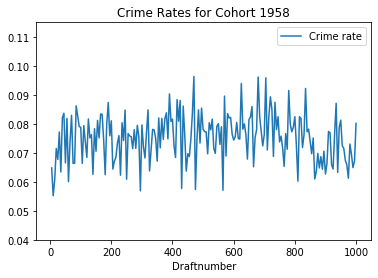

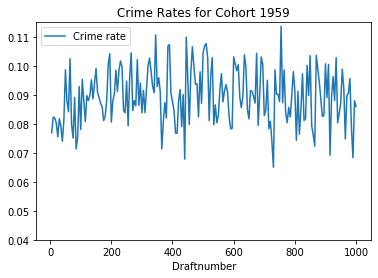

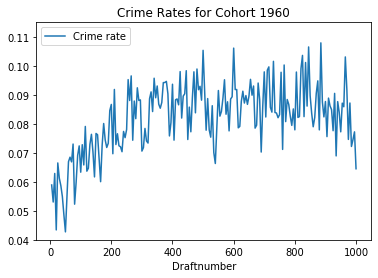

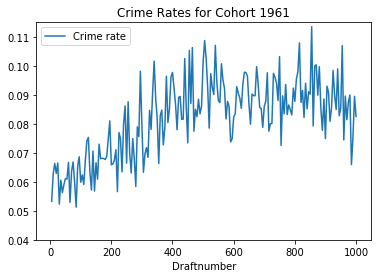

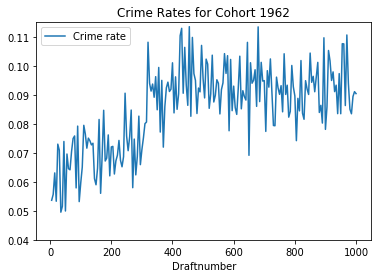

In [66]:
binned_plot(bin_num=200, ylim=[0.04, 0.115], years = list(range(1958, 1963, 1)))

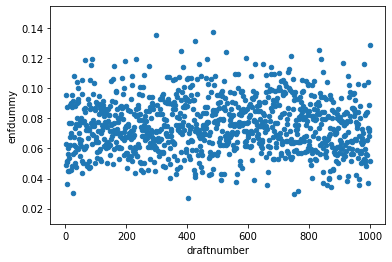

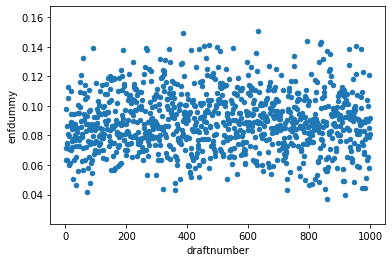

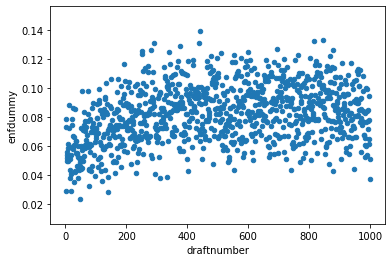

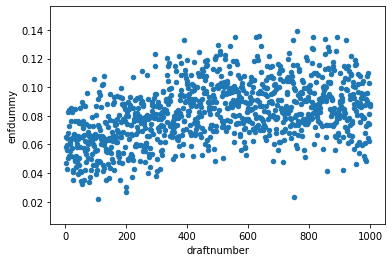

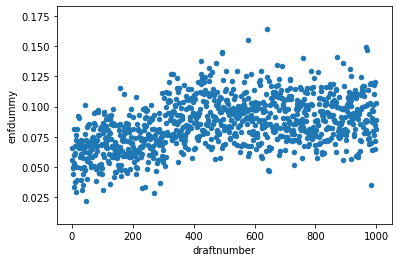

In [67]:
for i in years:
    df[df.cohort == i].plot.scatter(x='draftnumber', y='enfdummy')

Figure A.2

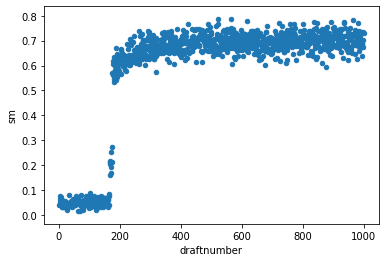

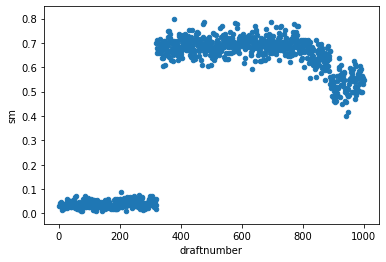

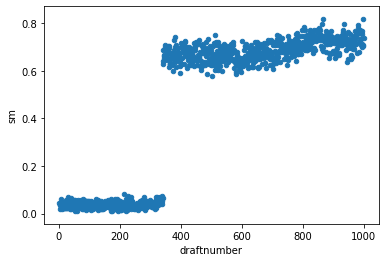

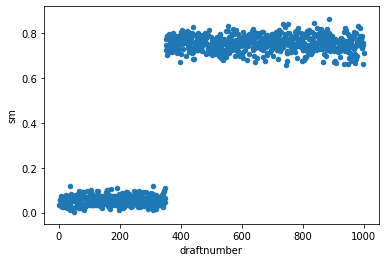

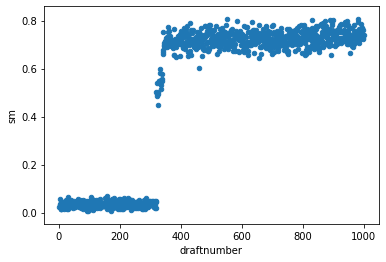

In [68]:
for i in years:
    df[df.cohort == i].plot.scatter(x='draftnumber', y='sm')

### 3.1 Extended "Testing" of Exogeneity of Instrument

Galinani et al. (2011) provide suggestive evidence of the plausibility of the exclusion restriction of the instrument *draft eligible*. Of course there are no statistical tests that really test the exogeneity of the instrument. They present some evidence that further supports the exogeneity of the instrument.

#### 3.1.1 Core cohorts: 1958 - 1962

Galiani et al. (2011) use the group of draft-exempt ID groups for each core cohort, create fake cutoff numbers, assigning each ID group to control and treatment, and test whether crime rates differ. For the fake cutoff number they use the median of the ID. Galiani et al. (2011) do not include the results of their tests neither in the paper nor the online appendix.
I extend the analysis by varying the fake cutoff number and by applying the same procedure on the observations that were draft eligible.

In [69]:
def test_fake_cutoff(df, highnumber):
    '''
    df data frame
    highnumber = 1 or highnumber = 0 test for draft eligible and exempt group
    
    '''
    
    for c in range(1958, 1963, 1):
        print(f'Cohort {c}')
        dfa = df[df.cohort == c][df.highnumber == highnumber][['crimerate', 'draftnumber']].copy()
        for q in np.linspace(0.1, 1, 9,endpoint=False):
            fake_cutoff = dfa.draftnumber.quantile(q)
            test = stats.ttest_ind(dfa.crimerate[dfa.draftnumber > fake_cutoff], dfa.crimerate[dfa.draftnumber < fake_cutoff],
                           axis=0, equal_var=False, nan_policy='propagate')
            print(f'Quantile = {q: .1f}', f'\n t-test = {test.statistic:.4f}', f'\n p-value = {test.pvalue:.4f}')
            if test.pvalue < 0.1 and test.pvalue > 0.05:
                print('*')
            elif test.pvalue <= 0.05 and test.pvalue > 0.01:
                print('**')
            elif test.pvalue <= 0.01:
                print('***')

In [70]:
#test_fake_cutoff(df=df, highnumber=0)

In [71]:
# Cutoffs implied by data set (integere associated with highnumber==0).
for c in range(1958, 1963, 1):
    print(df[df.cohort == c].highnumber.value_counts())

1.0    826
0.0    174
Name: highnumber, dtype: int64
1.0    681
0.0    319
Name: highnumber, dtype: int64
1.0    660
0.0    340
Name: highnumber, dtype: int64
1.0    651
0.0    349
Name: highnumber, dtype: int64
1.0    681
0.0    319
Name: highnumber, dtype: int64


#### 3.1.2 Cohorts 1956 and 1957

Cohorts of 1956 and 1957 were not drafted into the military due to a change in entry age of military service. According to Galiani et al. (2011), individuals knew well in advance they would not be coerced of entering military service.

#### 3.1.3 Cohort 1976 

Galiani et al. (2011) use the fact that the cohort of 1976 was assigned draft numbers but never actually served in the military. The draft numbers were assigned on May 27, 1994, but on August 31, 1994 conscription was abolished (ibid, p. 131). The authors employ the cutoff number of the cohort of 1975 and find no effect on crime rates. They argue that this ruled out all concerns that the instrument has an independent effect on crime rates (see section 1 for a discussion of potential pitfalls). Garano (2010) states that conscription was abolished because of a murder on a soldier on May 6, 1994 (p. 174). Therefore I do not find their argumentation based on the usage of the cohort of 1976 convincing and their instrument may be compromised. I extend their analysis by using a range of cutoff numbers.

### 3.2 Robustness checks 

#### 3.2.1 Table 6 with Controls

In table 6 include more controls than only cohort dummies.

#### 3.2.2 Table 4 for each Cohort Separately

Get table 4 for each cohort from 1958-1969

#### Table 5 with Army Dummy 

In table 5, columns 3 and 4, Galiani et al. (2011) use the data on military service in the navy. They use an indicator variable stating whether cohort-ID group *ci* was eligible for service in the navy or not. I extend upon their analysis by including a dummy for service in the army as well.

In [72]:
df.military.groupby(df.navy).mean()

navy
0.0    0.372189
1.0    0.498876
Name: military, dtype: float64

In [73]:
df.navy.value_counts()

0.0    42997
1.0     4003
Name: navy, dtype: int64

In [74]:
pd.crosstab(df.navy, df.military, margins=True)

military,0.0,1.0,All
navy,,,
0.0,26994,16003,42997
1.0,2006,1997,4003
All,29000,18000,47000


In [75]:
df.navy.value_counts()

0.0    42997
1.0     4003
Name: navy, dtype: int64

Get navy cutoff numbers.

In [76]:
for c in range(1958, 1963, 1):
    print(f'{c} \n', df[df.cohort == c].navy.value_counts())  # Numbers attached to navy==0 give respective cutoff.

1958 
 0.0    863
1.0    137
Name: navy, dtype: int64
1959 
 0.0    888
1.0    112
Name: navy, dtype: int64
1960 
 0.0    878
1.0    122
Name: navy, dtype: int64
1961 
 0.0    878
1.0    122
Name: navy, dtype: int64
1962 
 0.0    895
1.0    105
Name: navy, dtype: int64


### 3.3 Statistical Tests

Galiani et al. (2011) do not report F-tests of the applicability of *draft eligible* as an instrument for *conscription*. Having a strong instrument is crucial for the reliability of the instrumental variable approach. For the implications of a weak instrument, see section 1.2. Stock and Yogo (2002) find that an F-test statistic should be at least as large as 10, in order to rule out the possibility of a weak instrument. Better results are obtained if the F-test statistic is larger than 17.

In [77]:
# Get conditional means of 

In [78]:
(0.6587/0.0012)**2

301309.5069444444

## 4. Critical Assessment of Quality 

 - Same criticism to Angrist (1990) by Rosenzweig & Wolpin (2000) applicable to this study if mechanism thorugh labour market
 - Positive: they consider a deeper mechanism of conscription on crimerate. But they still go not deep enough.
 - Effect of 'navy': what if navy has otherwise detrimental effects that lead to crime rate to incr.?
 - Problems of intention-to-treat estimates
  - read sth up for this
  - check rsults: which crimes are committed more often? Is this in line with other research? Plausibility of the results.
 - Defiers: Authors do not argue why defiers are improbable; this is an assumption, nothing else.
 - Authors state that white collar and crimes against property should be larger if conscription detrimental effect on lM outcomes (p. 133). But same should apply to drug trafficking, since it also serves a pecuniary purpose, I'd argue.
 - Effect of navy: maybe other detrimental effects of serving in the navy. Implicit assump.: navy service same as air force and army on crime rates except for duration!

Get [back to top](#Content-of-this-Notebook).

## References 

Angrist, Joshua D. 1990. "Lifetime Earnings and the Vietnam Era Draft Lottery: Evidence from Social Security Administrative Records.". *American Economic Review*, 80 (3): 313-336

Angrist, Joshua D., Guido W. Imbens, and Donald B. Rubin. 1996. "Identification of Causal Effects Using Instrumental Variables." *Journal of the American Statistical Association*, 91:434, 444-455

Galiani, Sebastian, Martín A. Rossi, and Ernesto Schargrodsky. 2011. "Conscription and Crime: Evidence from the Argentine Draft Lottery." *American Economic Journal: Applied Economics*, 3 (2): 119-36.
[DOI: 10.1257/app.3.2.119](http://dx.doi.org/10.1257/app.3.2.119)

Garano, Santiago. 2010. "The Opposition Front against Compulsory Military Service: The Conscription Debate and Human-Rights Activism in Post-Conscription Debate and Human-Rights Activism in Post-dictatorship Argentina dictatorship Argent." *Genocide Studies and Prevention: An International Journal*, 5 (2): 174-190

Heckman, James. 1997. "Instrumental Variables: A Study of Implicit Behavioral Assumptions Used in MakingProgram Evaluations." *Journal of Human Resources*, 32 (3), 441-462

Imbens, Guido and Joshua Angrist. 1994. "Identification and Estimation of Local Average Treatment Effects." *Econometrica*, 62 (2): 467-75.
            
Pearl, J. 2014. "Causality." Cambridge, England: *Cambridge University Press*.

Rosenzweig, Mark, R., and Kenneth I. Wolpin. 2000. "Natural "Natural Experiments" in Economics." *Journal of Economic Literature*, 38 (4): 827-874.

Stock, James H., and Motohiro Yogo. 2002. "Testing for Weak Instruments in Linear IV Regression." *NBER Technical Working Paper*, No. 284

Winship, C., and S. L. Morgan. 2007. "Counterfactuals and causal inference: Methods and principles for social research." Cambridge, England: *Cambridge University Press*.